# OSM COMPETITION: A Predictive Model For Series Four Molecules

The aim of this competition is to develop a computational model that predicts which molecules will block the malaria parasite's ion pump, PfATP4.

## Preliminary Results

This report shows the results of applying Machine Learning techniques to:

1. Connect molecular structure to the survey results of the PfATPA ion regulation assay.

2. Connect molecular structure to compound potency against the malaria parasite.

James McCulloch. 


Data Preliminaries.

The dataset was prepared from the supplied spreadsheet “ION Regulation Data for OSM Competition.xls”. No additional compounds (e.g. from the Master Spreadsheet) were used.

Records were to be separated into “TRAIN” or “TEST” records for classification. All records with an “Ion Regulation Test Set” column of “B” or “C” were tagged as “TEST”.

# 1. ION_ACTIVITY Analysis

Data for ION_ACTIVITY analysis.

The ION_ACTIVITY field was generated from the “Ion Regulation Activity” spreadsheet column and was treated as a classification field with “ACTIVE” = 1, “PARTIAL” = 0.5 (only a few of these) and “INACTIVE” = 0.

From a total of 703 valid records in the competition spreadsheet (SMILES available) there were 438 "TRAIN" records and 35 "TEST" records with a valid ION_ACTIVITY.

ION_ACTIVITY analysis methodology.

A number of Machine Learning classifiers (tabulated below ) were trained against various molecular descriptors (tabulated below) of the "TRAIN" records then the 35 "TEST" records were presented to the trained ML classifiers. The results of the ability of the ML classifier to determine the ION_ACTIVITY status of "TEST" molecules are tabulated below as a micro Area Under Curve (AUC) statistic (since this is a 3 class classification problem, see SKlearn for examples and documentation of micro AUC). Like AUC, a statistic of 0.0 is perfect anti-classification, 0.5 is random classification (no information) and 1 is perfect classification. 

In [3]:
from IPython.display import display
import pandas as pd
ion_results = pd.read_csv("./ion_results.csv")
display(ion_results)

,MODEL,MCCFP,M2048,M2048_4,TOP2048,DRAGON
0,DTC,0.53,0.55,0.66,0.53,0.66
1,LOGC,0.69,0.63,0.63,0.66,0.70
2,KNNC,0.67,0.69,0.67,0.78,0.69
3,SVMC,0.65,0.66,0.65,0.65,0.67
4,NBC,0.72,0.65,0.70,0.61,0.62
5,DNN,0.65,0.62,0.63,0.66,0.67


Where the ML MODELs are as follows:

1. DTC - A Decision Tree model from SKLearn.
2. LOGC - A Logistic classifier from SKLearn.
3. KNNC - K Nearest Neighbours classifier from SKLearn.
4. SVMC - A Support Vector Machine classifier from SKLearn.
5. NBC - A Naive Bayes classifier from SKLearn.
6. DNN - A Deep Neural Network classifier [2048, 64, 64, 16, 3] from the Keras toolkit (or TensorFlow for the DRAGON descriptor)

The molecular descriptors are as folows:

1. MCCFP - The MACCS molecular fingerprint from RDKIT
2. M2048 - A 2048 bit, radius = 2, Morgan fingerprint from RDKIT
3. M2048_4 - A 2048 bit, radius = 4, Morgan fingerprint from RDKIT
4. TOP2048 - A 2048 bit Topological fingerprint from RDKIT
5. DRAGON - A vector of 1552 pharmacophore molecular fields scaled to be on the interval [0, 1]. The original Dragon download consisted of 1666 fields but uninformative (unchanging) fields have been removed.

Modelling.

To run these models, download (follow the readme setup) the software on gitHub here: https://github.com/kellerberrin/OSM-QSAR

For the SKLearn models (--help for flag decriptions) the following cmd was used:

$python OSM_QSAR.py --classify [model] --depend ION_ACTIVITY --indep [descriptor] --clean

For the Keras NN (except MACCFP):

$python OSM_QSAR.py --classify bin_m --depend ION_ACTIVITY --indep [descriptor] --train 500 --check 20 --clean

For the TensorFlow NN (DRAGON)

$python OSM_QSAR.py --classify tfdnn --depend ION_ACTIVITY --indep DRAGON --train 5000 --check 25 --clean

Note that training the DNN on the DRAGON descriptor was challenging with the DNN failing to converge (Keras) or wandering all over the objective function (cross entropy). However, the TensorFlow DNN eventually converges after much to-ing and fro-ing (the --check flag allows you to observe its unsteady progress across the objective function). Interestingly, Keras is just a front end to TensorFlow and both models use "Adam" (best by trial and error) as stochastic optimizer.

The problem is dimensionality, we have 438 training records and DRAGON has 1552 busy fields. Note that while it is true that the fingerprints have a notional dimensionality of 2048, most of the vector is empty and 'effective' dimension is much lower. 


Results Discussion.

The summary micro AUC values recorded in the results are modest at best. However, when we examine the classification results in detail, there are some important and robust conclusions. 

We examine the detailed classification results from the Naive Bayes classifier (nbc) using the Morgan (radius 4) fingerprint and compare this to the DNN (Tensorflow) results using the DRAGON descriptors. 

1. The completely different ML models and descriptiors produce very similar results and molecular ranking. This implies that our results are robust.

2. When we examine the molecules classified as "ACTIVE" we see that they all have the same or similar scaffolds. Examining Greg Landrum's similarity maps (below) also confirms that ION_ACTIVITY comes from the same molecular fragment.

3. When we compare two very similar molecules OSM201 (INACTIVE) and OSM204 (ACTIVE) that are classified as ACTIVE the small differences between the 2 molecules allows for an interesting way of inferring the characteristics of the relevent 'pocket' in PfATP4 since we can be fairly certain that these molecules dock (or not) to the same pocket.    

4. This process gives us a methodology of identifying important ION_ACTIVITY pharmacophore molecular fields in the DRAGON descriptor vector (and reducing the dimensionality of the vector).

5. When we examine the detailed training classification results,  we find that the reason that only 1 active molecular scaffold is identified is that other active scaffolds are missing or under-represented in the training molecule set. This also confirms point 1. The classification process is robust and the addition of molecules with different scaffolds that are ACTIVE will significantly improve solve model classification.  


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)
import time
print(time.asctime())

2016.09.4
Sun Mar 19 09:40:07 2017


The RDKit has had the ability to display molecules in the Jupyter (formerly IPython) notebook for quite a while. The original drawing code was purely Python based, but work is underway to replace that code with a C++ molecule renderer (this is the package `rdkit.Chem.Draw.rdMolDraw2D` in Python) so that the same drawings are available in systems other than Python.

This new rendering code is, when available, now the default in Jupyter.

If the RDKit has been built with Cairo support, `rdMolDraw2D` will be used to produce molecule drawings:

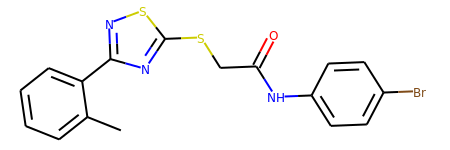

In [2]:
m = Chem.MolFromSmiles('Cc1ccccc1c2nsc(SCC(=O)Nc3ccc(Br)cc3)n2') # molecule from the 2014 TDT challenge
m

But on platforms where this is not the case, the older Python rendering is used to produce images.

On browsers with good SVG support (most, if not all of them these days), you can use tell Jupyter to use SVG to render molecules, this will cause the `rdMolDraw2D` renderer to always be used:

In [3]:
IPythonConsole.ipython_useSVG=True

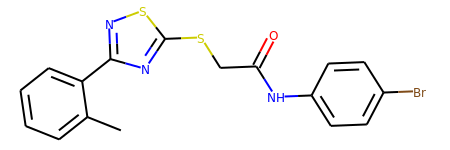

In [4]:
m

The drawings look quite similar to each other, but the SVG version has the advantage that, because SVG is a vector format, it scales nicely if you zoom in or out.

`Draw.MolsToGridImage()` now uses the new renderer too:

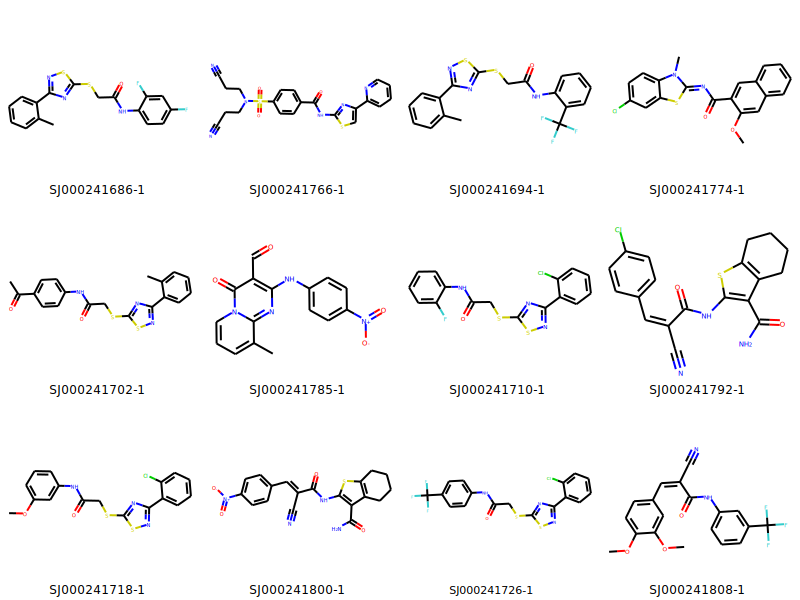

In [5]:
# molecules from the 2014 TDT challenge
d=[('SJ000241686-1', 'Cc1ccccc1c2nsc(SCC(=O)Nc3ccc(F)cc3F)n2'),
 ('SJ000241766-1', 'O=C(Nc1nc(cs1)c2ccccn2)c3ccc(cc3)S(=O)(=O)N(CCC#N)CCC#N'),
 ('SJ000241694-1', 'Cc1ccccc1c2nsc(SCC(=O)Nc3ccccc3C(F)(F)F)n2'),
 ('SJ000241774-1', 'COc1cc2ccccc2cc1C(=O)\\N=C\\3/Sc4cc(Cl)ccc4N3C'),
 ('SJ000241702-1', 'CC(=O)c1ccc(NC(=O)CSc2nc(ns2)c3ccccc3C)cc1'),
 ('SJ000241785-1', 'CC1=CC=CN2C(=O)C(=C(Nc3ccc(cc3)[N+](=O)[O-])N=C12)C=O'),
 ('SJ000241710-1', 'Fc1ccccc1NC(=O)CSc2nc(ns2)c3ccccc3Cl'),
 ('SJ000241792-1', 'NC(=O)c1c2CCCCc2sc1NC(=O)\\C(=C/c3ccc(Cl)cc3)\\C#N'),
 ('SJ000241718-1', 'COc1cccc(NC(=O)CSc2nc(ns2)c3ccccc3Cl)c1'),
 ('SJ000241800-1',
  'NC(=O)c1c2CCCCc2sc1NC(=O)\\C(=C\\c3ccc(cc3)[N+](=O)[O-])\\C#N'),
 ('SJ000241726-1', 'FC(F)(F)c1ccc(NC(=O)CSc2nc(ns2)c3ccccc3Cl)cc1'),
 ('SJ000241808-1', 'COc1ccc(\\C=C(\\C#N)/C(=O)Nc2cccc(c2)C(F)(F)F)cc1OC')]
ms = [Chem.MolFromSmiles(y) for x,y in d]
labels = [x for x,y in d]
Draw.MolsToGridImage(ms,legends=labels,molsPerRow=4)

The new renderer is also better at dealing with highlighting than the old one:

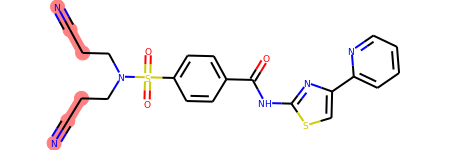

In [6]:
ms[1].GetSubstructMatches(Chem.MolFromSmarts('CC#N'))
ms[1]

The Jupyter notebook integration code does some work behind the scenes in order to get a better depiction that it's worth knowing about if you plan to work with images or SVGs directly.

Here's the default rendering that one gets:

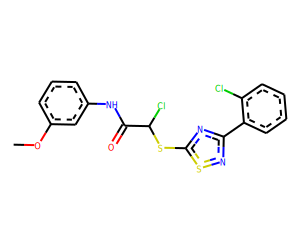

In [7]:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor

m = Chem.MolFromSmiles('COc1cccc(NC(=O)[C@H](Cl)Sc2nc(ns2)c3ccccc3Cl)c1') # something I made up
rdDepictor.Compute2DCoords(m)
d2d = rdMolDraw2D.MolDraw2DSVG(300,250)
d2d.DrawMolecule(m)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
SVG(svg.replace("svg:",""))

Notice that I had to explicitly generate coordinates for this molecule built from SMILES, that the bonds around the chiral center are not wedged, and that the aromatic rings haven't been kekulized. These can all be handled at once using the new function `rdMolDraw2D.PrepareMolForDrawing()` :

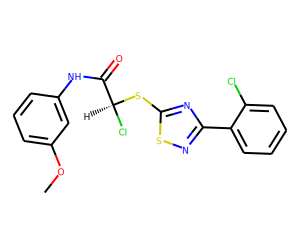

In [8]:
m = Chem.MolFromSmiles('COc1cccc(NC(=O)[C@H](Cl)Sc2nc(ns2)c3ccccc3Cl)c1') # something I made up
tm = rdMolDraw2D.PrepareMolForDrawing(m)
d2d = rdMolDraw2D.MolDraw2DSVG(300,250)
d2d.DrawMolecule(tm)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
SVG(svg.replace("svg:",""))

The Jupyter integration code does this work for you:

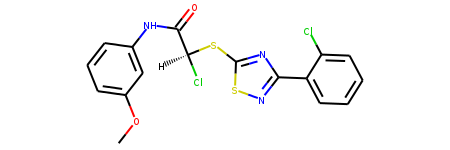

In [9]:
m = Chem.MolFromSmiles('COc1cccc(NC(=O)[C@H](Cl)Sc2nc(ns2)c3ccccc3Cl)c1') # something I made up
m

Notice that this also adds a hydrogen to the chiral center. This results in clearer renderings than the previous behavior, which would just wedge one of the other bonds. The difference is particularly visible with complex fused ring systems:

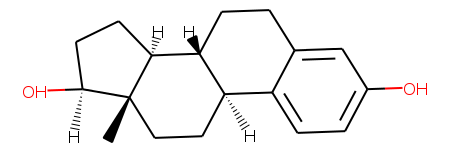

In [10]:
estradiol=Chem.MolFromSmiles('C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O')
estradiol

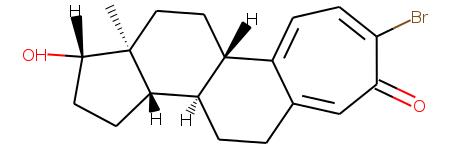

In [11]:
om = Chem.MolFromSmiles('C[C@]12CC[C@@H]3c4ccc(Br)c(=O)cc4CC[C@H]3[C@@H]1CC[C@@H]2O')
om